# TP 3: Implémentation de module, Gestion de données, Checkpointing et GPU

_Ismaël Bonneau & Issam Benamara_

Le vrai code, comme les imports, le chargement des données se trouve dans le fichier _tp3.py_. Ce rapport sert à présenter l'avancée de notre travail et notre compréhension du sujet.

### Dataset & Dataloader

Nous avons exploré les possibilités des dataloaders et datasets.

Un ***Dataset*** en pytorch: classe encapsulant des données labelisées (ou non) X et Y.


Un ***DataLoader***: interface de manipulation d'un dataset fournissant un itérateur dessus et de nombreuses options utiles. Parmi elles, on peut noter:

- ***batch_size***, qui permet de parcourir le dataloader comme un itérable sur le dataset en nous renvoyant des batches x, y de la taille spécifiée. Très utile. 
- ***shuffle***, qui dit au dataloader de re mélanger dans un ordre random les exemples du dataset à chaque itération dessus ( = chaque _epoch_ de l'apprentissage)
- ***sampler et batch_sampler*** qui permettent de spécifier la méthode de sampling des exemples.
- ***collate_fn*** permet de spécifier la façon dont on veut assembler les données (par défaut, renvoie un tuple (exemple(s), label(s). 

#### Voici un exemple de dataset pour MNIST qui renvoie un couple (Tenseur 1D, label) pour chaque image

In [15]:
class Dataset_MNIST(Dataset):
    def __init__(self, x, y):
        super(Dataset_MNIST, self).__init__()
        self.labels = torch.from_numpy(y)
        self.data = torch.from_numpy(x).float()
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    def __len__(self):
        return len(self.labels)

Le dataloader associé avec une taille de batch de 40 sera créé ainsi:

In [ ]:
train_dataset = Dataset_MNIST(X_train, y_train)
trainloader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)

### Implémentation d'un tied auto-encoder

Un auto encoder permet d'encoder des objets dans un espace de dimension plus petite, pour en créer une représentation de plus haut niveau. On guide la construction de cet espace en cherchant à reconstruire les objets de départ d'après l'espace latent de façon la plus précise possible. 

Dans le cas d'un tied auto-encoder, les paramètres servant à l'encodage sont les mêmes que ceux servant au décodage. Cela présente plusieurs avantages:

- Cela fait moins de paramètres à apprendre.
- Il s'agit d'une façon de régulariser.
- C'est au final très proche d'une PCA.

In [14]:
class TiedAutoEncoder(nn.Module):
    """ tied AutoEncoder: encoder and decoder share weights"""
    def __init__(self, input_dim, latent):
        super(TiedAutoEncoder, self).__init__()
        self.W = torch.nn.Parameter(torch.randn(input_dim, latent), requires_grad=True)
        self.b1 = torch.nn.Parameter(torch.randn(1), requires_grad=True)# bias for encoder
        self.b2 = torch.nn.Parameter(torch.randn(1), requires_grad=True)# bias for decoder

    def encode(self, x):
        return nn.functional.relu(x @ self.W + self.b1)

    def decode(self, x):
        return torch.sigmoid(x @ self.W.t() + self.b2)

    def forward(self, x):
        return self.decode(self.encode(x))

#### On pourra comparer avec un auto encoder classique:

In [74]:
class AutoEncoder(nn.Module):
    """ classical & simple AutoEncoder """
    def __init__(self, input_dim, latent):
        super(AutoEncoder, self).__init__()
        self.encoder = torch.nn.Linear(input_dim, latent)
        self.decoder = torch.nn.Linear(latent, input_dim)

    def encode(self, x):
        return nn.functional.relu(self.encoder(x))

    def decode(self, x):
        return torch.sigmoid(self.decoder(x))

    def forward(self, x):
        return self.decode(self.encode(x))

### GPU & checkpoints



In [ ]:
class State:
    def __init__(self, model, optim):
    self.model = model
    self.optim = optim
    self.epoch, self.iteration = 0, 0

### Campagne d'expériences:

- Evaluer l'influence de la taille de l'espace latent dans la qualité de la reconstruction
- Comparer Tied Autoencoder et Autoencoder classique


Pour cette campagne d'expériences, on prendra les données MNIST, qui sont des images d'écriture manuscrite de chiffres entre 0 et 9. Ces images sont en taille 28x28 pixels

| modèle        | dimension 10          | dimension 50  | dimension 100  |
| ------------- |:-------------:| -----:| -----:|
| Tied AutoEncoder      | right-aligned | caca | caca |
| AutoEncoder     | centered      |   caca | caca |

<img src="tiedautoencoder.png">
<img src="autoencoder.png">

In [2]:
import numpy as np
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import normalize

# Dataset d'images MNIST

class Dataset_MNIST(Dataset):
    def __init__(self, x, y):
        super(Dataset_MNIST, self).__init__()
        self.labels = torch.from_numpy(y)
        self.data = torch.from_numpy(x).float()
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    def __len__(self):
        return len(self.labels)

In [3]:
seed = 1997
torch.manual_seed(seed)

X_train, y_train = loadlocal_mnist(images_path='/home/ismael/Documents/master/AMAL/TP3/mnist/train-images.idx3-ubyte',
                                   labels_path='/home/ismael/Documents/master/AMAL/TP3/mnist/train-labels.idx1-ubyte')

X_test, y_test = loadlocal_mnist(images_path='/home/ismael/Documents/master/AMAL/TP3/mnist/t10k-images.idx3-ubyte',
                                 labels_path='/home/ismael/Documents/master/AMAL/TP3/mnist/t10k-labels.idx1-ubyte')

# images sous forme de vecteurs
print("train shapes: ", X_train.shape, y_train.shape)
print("test shapes: ", X_test.shape, y_test.shape)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train /= 255.
X_test /= 255.

train shapes:  (60000, 784) (60000,)
test shapes:  (10000, 784) (10000,)


In [11]:
import matplotlib.pyplot as plt

def afficher(x):
    plt.axis("off")
    plt.imshow(x.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    plt.show()

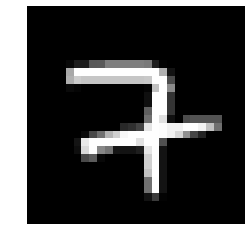

In [13]:
afficher(X_train[38])

In [16]:
train_dataset = Dataset_MNIST(X_train, y_train)
trainloader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)

test_dataset = Dataset_MNIST(X_test, y_test)
testloader = DataLoader(dataset=test_dataset, batch_size=40, shuffle=False)

latent_dim = 100 # encoder en dimension 100

In [75]:
model = AutoEncoder(X_train.shape[1], 5) 

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [76]:
epochs = 70

for e in range(epochs):
    for image_batch, label_batch in trainloader:
        model.train()
        optimizer.zero_grad()

        reconstructed = model(image_batch)
        loss = criterion(image_batch, reconstructed)

        loss.backward()
        optimizer.step()

In [77]:
def predict(index):
    with torch.no_grad():
        pred = model(torch.from_numpy(X_test[index]).float())
        return pred

In [78]:
def comparer(original, reconstructed):
    fig, axs = plt.subplots(1, 2)
    axs[0].axis("off")
    axs[0].set_title("original")
    axs[0].imshow(original.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    axs[1].axis("off")
    axs[1].set_title("reconstructed")
    axs[1].imshow(reconstructed.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    plt.show()

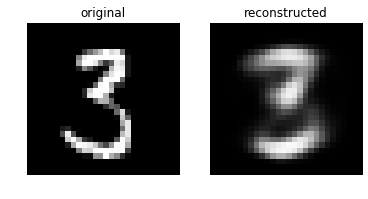

In [79]:
x_test_1997 = predict(1997)
comparer(X_test[1997], x_test_1997)

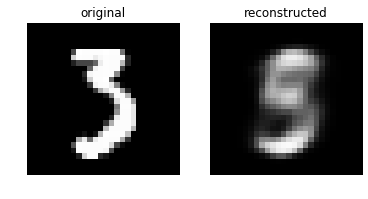

In [80]:
x_test_1998 = predict(1976)
comparer(X_test[1976], x_test_1998)

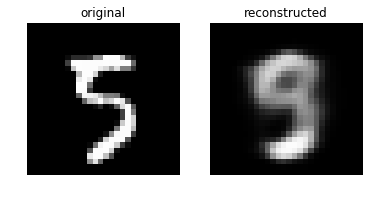

In [82]:
x_test_1998 = predict(1999)
comparer(X_test[1999], x_test_1998)